In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import sys
sys.path.insert(0, './simile')

import simile as sml
import importlib
importlib.reload(sml)

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from rdkit.Chem import MolFromSmiles, rdFMCS

## Load Data

In [2]:
df = pd.read_json('./example_data/fig5b.json')

mzi1 = np.array(df.iloc[0].spectrum)
mzi2 = np.array(df.iloc[1].spectrum)

pmz1 = df.iloc[0].precursor_mz
pmz2 = df.iloc[1].precursor_mz

mol1 = MolFromSmiles(df.iloc[0].smiles)
mol2 = MolFromSmiles(df.iloc[1].smiles)

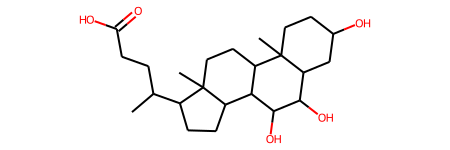

In [3]:
mol1

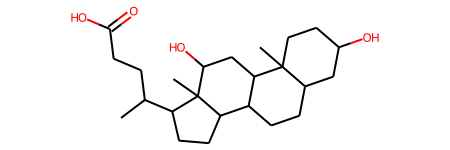

In [4]:
mol2

## MCS Jaccard Similarity

In [5]:
res = rdFMCS.FindMCS([mol1,mol2],timeout=10,ringMatchesRingOnly=False)
A = mol1.GetNumBonds()
B = mol2.GetNumBonds()
AB = res.numBonds
jaccard_similarity = AB / ((A+B) - AB)
jaccard_similarity

0.9090909090909091

## SIMILE Substitution Matrix, Alignment Score, and Alignment P-value

/Users/dgct/Repos/simile/simile.py:113: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  match_scores = S[[tuple(col_match),tuple(row_match)]]
/Users/dgct/Repos/simile/simile.py:139: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  idx = np.argsort(S[[tuple(matches.T[1]),tuple(matches.T[0])]])[::-1]


Score: 0.5126508167942753, P-value: 0.001, # Matching Ions 12


<AxesSubplot:>

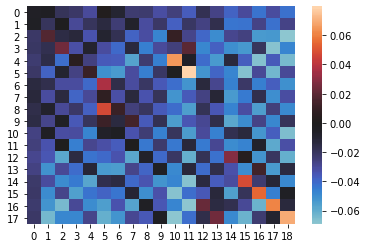

In [6]:
S = sml.similarity_matrix(mzi1[0], mzi2[0], pmz1, pmz2, tolerance=.01)

simile_score,simile_matches = sml.pairwise_match(S[:mzi1.shape[1],mzi1.shape[1]:])

simile_matches = sml.sort_matches(S[:mzi1.shape[1],mzi1.shape[1]:], simile_matches)

simile_pval = sml.significance_test(S, mzi1[0], mzi2[0], pmz1, pmz2, kind='match')

print('Score: {}, P-value: {}, # Matching Ions {}'.format(simile_score, simile_pval, simile_matches.shape[0]))
sns.heatmap(S[:mzi1.shape[1],mzi1.shape[1]:],center=0,linewidths=0.0, rasterized=True)

## SIMILE Matches MZs and MZ Differences (Sorted by Decreasing Similarity)

In [7]:
np.set_printoptions(suppress=True)
np.array([mzi1[0,simile_matches.T[1]],
          mzi2[0,simile_matches.T[0]],
          mzi1[0,simile_matches.T[1]]-
          mzi2[0,simile_matches.T[0]]]).T

array([[372.2634, 356.2686,  15.9948],
       [408.2841, 392.2896,  15.9945],
       [371.26  , 355.2651,  15.9949],
       [407.2809, 391.2864,  15.9945],
       [406.269 , 390.2746,  15.9944],
       [405.2658, 389.2711,  15.9947],
       [375.2548, 343.2651,  31.9897],
       [389.2708, 373.2758,  15.995 ],
       [370.2479, 328.2732,  41.9747],
       [369.2444, 327.2702,  41.9742],
       [378.2741, 346.2842,  31.9899],
       [377.2713, 345.2809,  31.9904]])

## Modified Cosine Alignment MZs and MZ Differences

In [8]:
modcos_alignment = np.argwhere(np.isclose(np.subtract.outer(mzi2[0],mzi1[0]), 0,         rtol=0,atol=.01)| 
                               np.isclose(np.subtract.outer(mzi2[0],mzi1[0]), pmz2-pmz1, rtol=0,atol=.01))

In [9]:
np.set_printoptions(suppress=True)
np.array([mzi1[0,modcos_alignment.T[1]],
          mzi2[0,modcos_alignment.T[0]],
          mzi1[0,modcos_alignment.T[1]]-
          mzi2[0,modcos_alignment.T[0]]]).T

array([[371.26  , 355.2651,  15.9949],
       [372.2634, 356.2686,  15.9948],
       [389.2708, 373.2758,  15.995 ],
       [389.2708, 389.2711,  -0.0003],
       [405.2658, 389.2711,  15.9947],
       [390.2742, 390.2746,  -0.0004],
       [406.269 , 390.2746,  15.9944],
       [407.2809, 391.2864,  15.9945],
       [408.2841, 392.2896,  15.9945]])

## SIMILE Matches (x) vs Modified Cosine Alignment (+) 

/Users/dgct/anaconda/envs/simile-example/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


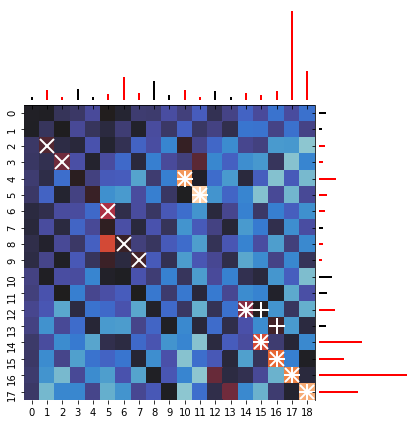

In [10]:
def pairgrid_heatmap(mzs,intensities,S,n,ax, **kws):
    sns.heatmap(S[:n,n:],center=0,ax=ax, cbar=False,linewidths=0.0, rasterized=True)
    
    ax.plot(*modcos_alignment[::-1].T+.5,'w+',markersize=100/len(mzs)**.5,alpha=1,markeredgewidth=2)
    ax.plot(*simile_matches[::-1].T+.5,'wx',markersize=80/len(mzs)**.5,alpha=1,markeredgewidth=2)
    

mzs,intensities=np.concatenate([mzi1,mzi2],axis=1)
intensities = intensities**.5
n = len(mzi1[0])

p = sns.JointGrid(mzs,intensities,ratio=3,space=0)
p.plot_joint(pairgrid_heatmap, S=S, n=n, ax=p.ax_joint, cax=p.ax_marg_y, fig=p.fig)

p.ax_marg_x.vlines(np.arange(len(intensities)-n)+.5, 
                   np.zeros_like(intensities[n:]), 
                   intensities[n:],linewidth=2,
                   color='black')
p.ax_marg_x.vlines(simile_matches[::-1].T[0]+.5, 
                   np.zeros_like(intensities[n:][simile_matches[::-1].T[0]]), 
                   intensities[n:][simile_matches[::-1].T[0]],linewidth=2,
                   color='r')

p.ax_marg_y.hlines(np.arange(n)+.5, 
                   np.zeros_like(intensities[:n]), 
                   intensities[:n],linewidth=2,
                   color='black')
p.ax_marg_y.hlines(simile_matches[::-1].T[1]+.5, 
                   np.zeros_like(intensities[:n][simile_matches[::-1].T[1]]), 
                   intensities[:n][simile_matches[::-1].T[1]],linewidth=2,
                   color='r')
